In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


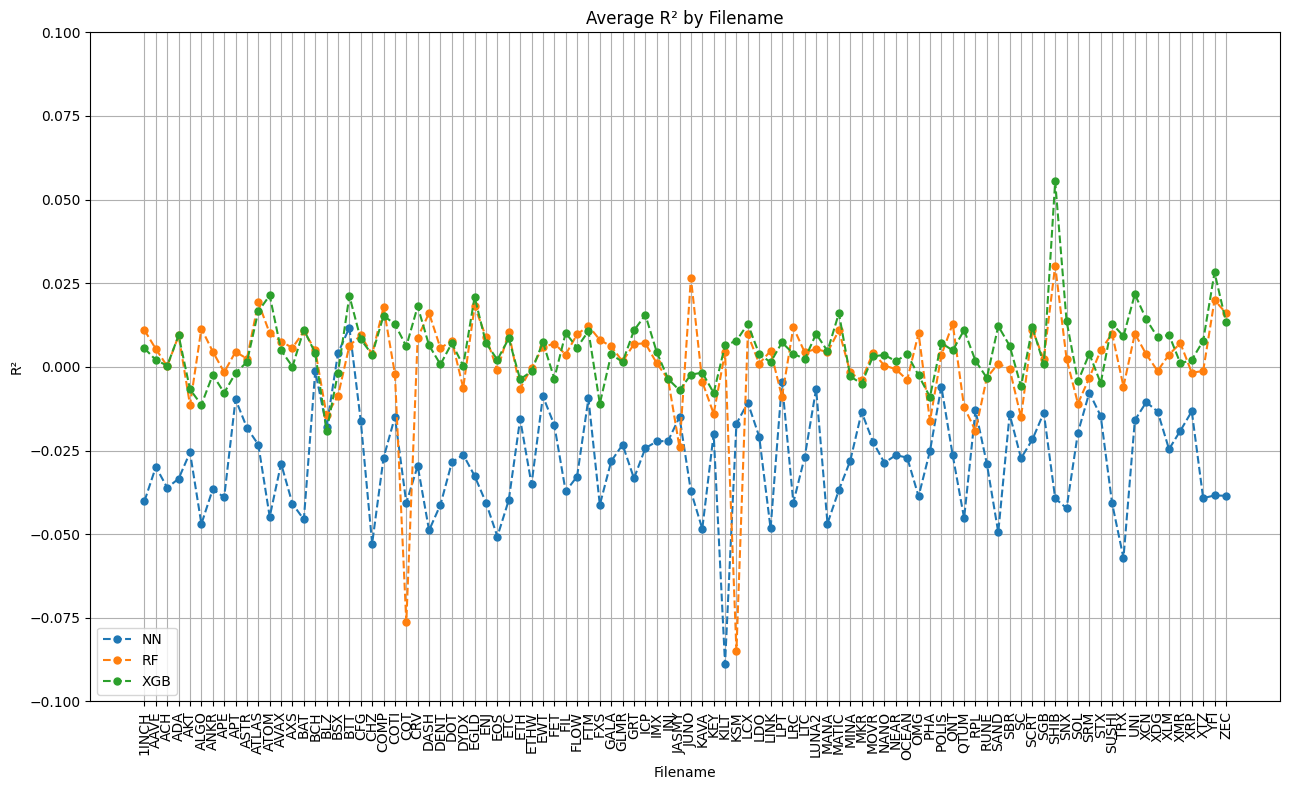

In [2]:
files = {
    'NN':  '../modeling/MLPRegressor_predictions_one_model.parquet',
    'RF':  '../modeling/RF_predictions_one_model.parquet',
    'XGB': '../modeling/XGB_predictions_one_model.parquet',
    # 'RF_ind': '../modeling/RF_predictions_ind_models.parquet',
}

# gather all coin names across files
all_coins = set()
for path in files.values():
    tmp = pd.read_parquet(path)
    coins = tmp['filename'].str.split('_').str[0].str[:-3]
    all_coins |= set(coins.unique())
coin_names = sorted(all_coins)
x = np.arange(len(coin_names))

fig, ax = plt.subplots(figsize=(13, 8))

for label, path in files.items():
    res = pd.read_parquet(path)
    res['coin_name'] = res['filename'].str.split('_').str[0].str[:-3]
    r2_scores = (
        res.groupby('coin_name')
           .apply(lambda x: r2_score(x['next_return'], x['pred']))
           .reindex(coin_names)   # align to full coin list
    )
    y = r2_scores.values
    ax.plot(x, y, 'o--', markersize=5, label=label)

ax.set_xticks(x)
ax.set_xticklabels(coin_names, rotation=90)
ax.set_xlabel("Filename")
ax.set_ylabel("R²")
ax.set_title("Average R² by Filename")
ax.set_ylim(-0.1, 0.1)
ax.grid(True)
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [22]:
def plot_r2_metrics(all_preds):
    r2_metrics = {}
    count_metrics = {}

    for thr in np.arange(0, 1, 0.005):
        subset = all_preds.loc[np.abs(all_preds['pred']) >= thr]
        n = len(subset)
        if n == 0:
            break

        count_metrics[thr] = n

        r2_metrics[thr] = r2_score(subset['next_return'], subset['pred'])
        if r2_metrics[thr] < -3:
            r2_metrics[thr] = -3
            break

    r2_metrics = pd.Series(r2_metrics).sort_index()
    count_metrics = pd.Series(count_metrics).sort_index()
    # print(f"R² metrics: {r2_metrics}")
    # print(f"Count metrics: {count_metrics}")
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.plot(
        r2_metrics.index,
        r2_metrics.values,
        marker='o',
        color='green',
        label='R²'
    )
    ax1.axhline(0, color='red', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Threshold on |pred|')
    ax1.set_ylabel('R²', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    x_vals = r2_metrics.index.values
    y_vals = r2_metrics.values
    y_min, y_max = y_vals.min(), y_vals.max()
    offset = (y_max - y_min) * 0.04
    for i in range(len(y_vals)):
        y_curr = y_vals[i]
        y_next = y_vals[i + 1] if i < len(y_vals) - 1 else y_vals[i - 1]
        y_prev = y_vals[i - 1] if i > 0 else y_vals[i + 1]

        if y_next > y_curr and y_prev > y_curr:
            y_pos = y_curr - offset
            va = 'bottom'
        elif y_next <= y_curr and y_prev <= y_curr:
            y_pos = y_curr + offset
            va = 'top'
        else:
            y_pos = y_curr - offset
            va = 'bottom'

        ax1.text(
            x_vals[i],
            y_pos,
            f"{y_curr:.2f}",
            ha='center',
            va=va,
            fontsize=8,
            color='green'
        )


    ax2 = ax1.twinx()
    bars = ax2.bar(
        count_metrics.index,
        count_metrics.values,
        width=0.005,
        alpha=0.3,
        color='blue',
        label='Count'
    )
    ax2.set_ylabel('Number of samples (log scale)', color='blue')
    ax2.set_yscale('log')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax2.set_ylim(1, count_metrics.max() * 100)

    for x, y in zip(count_metrics.index, count_metrics.values):
        ax2.text(
            x,
            y * 1.05,
            str(int(y)),
            ha='center',
            va='bottom',
            fontsize=6,
            color='blue'
        )

    fig.tight_layout()
    plt.show()


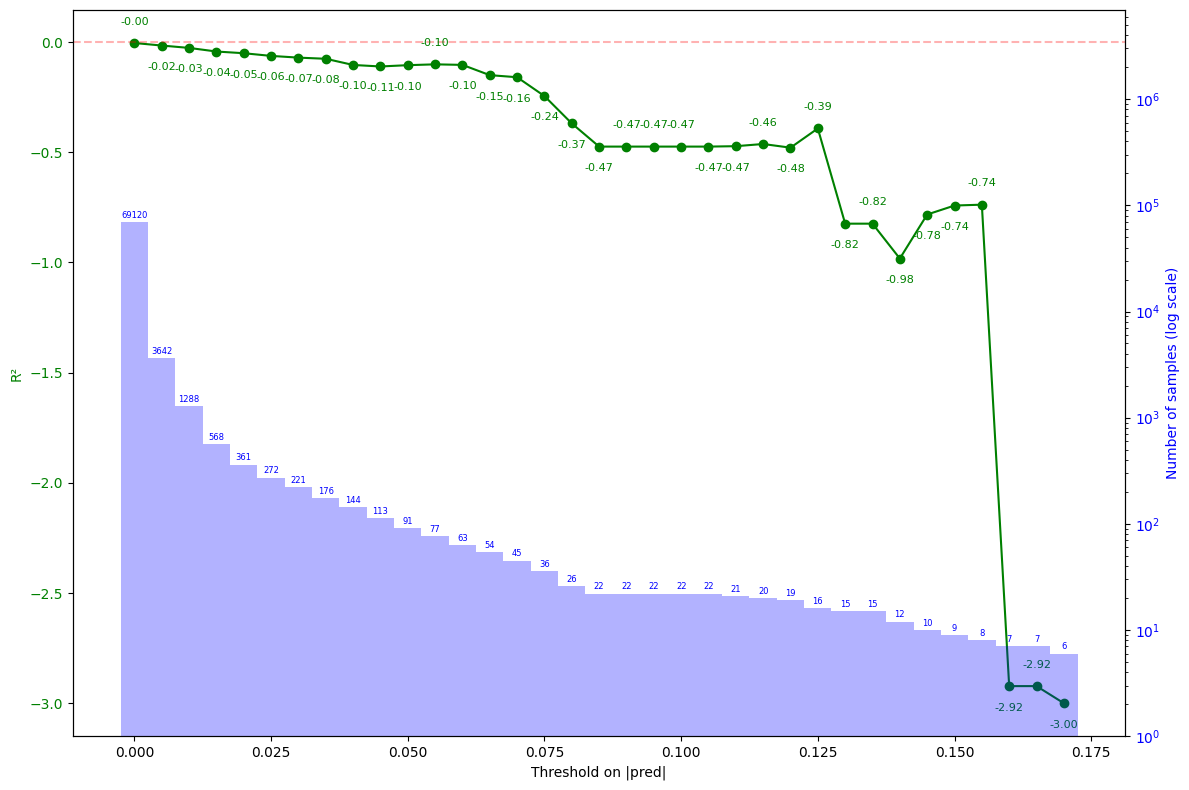

In [23]:
plot_r2_metrics(pd.read_parquet(files['RF']))

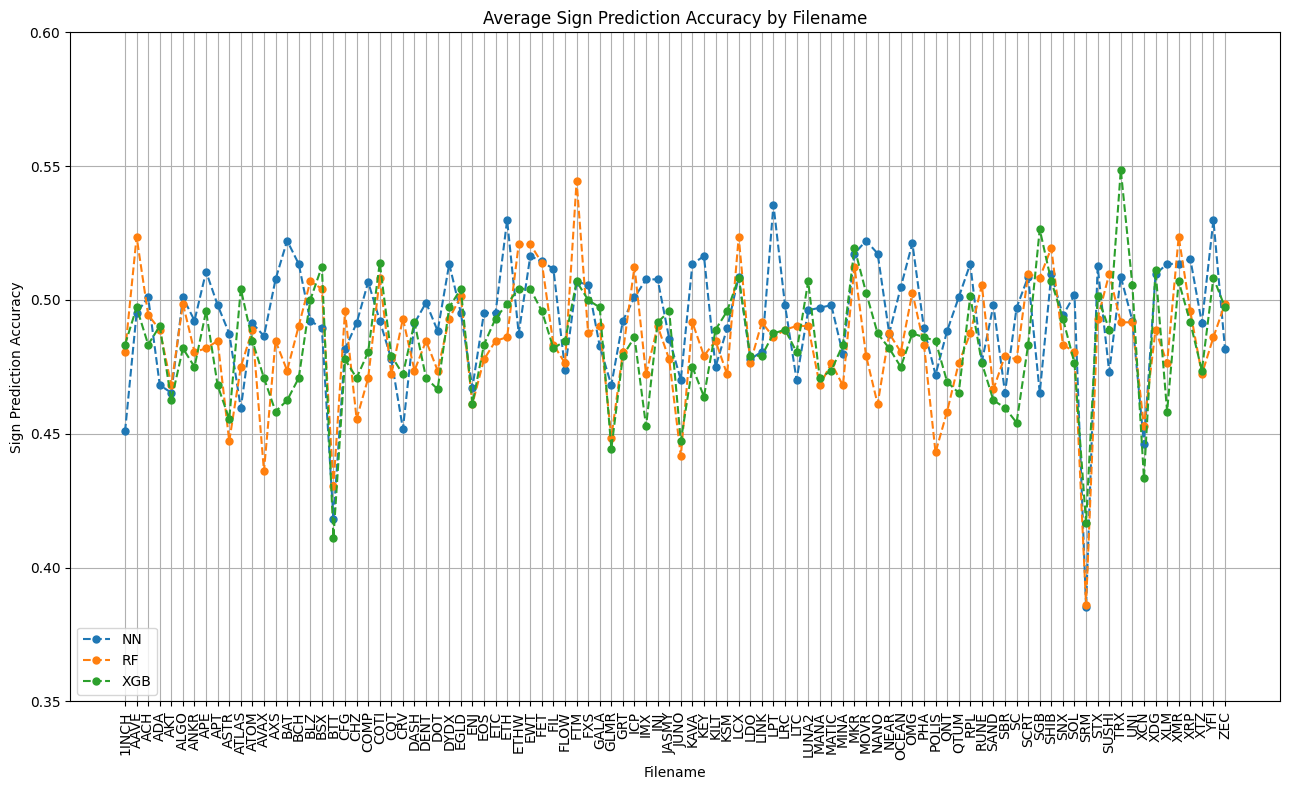

In [28]:
files = {
    'NN':  '../modeling/MLPRegressor_predictions_one_model.parquet',
    'RF':  '../modeling/RF_predictions_one_model.parquet',
    'XGB': '../modeling/XGB_predictions_one_model.parquet',
}

# gather all coin names across files
all_coins = set()
for path in files.values():
    tmp = pd.read_parquet(path)
    coins = tmp['filename'].str.split('_').str[0].str[:-3]
    all_coins |= set(coins.unique())
coin_names = sorted(all_coins)
x = np.arange(len(coin_names))

fig, ax = plt.subplots(figsize=(13, 8))

for label, path in files.items():
    res = pd.read_parquet(path)
    res['coin_name'] = res['filename'].str.split('_').str[0].str[:-3]
    r2_scores = (
        res.groupby('coin_name')
           .apply(lambda x: np.mean(np.sign(x['next_return']) == np.sign(x['pred'])))
           .reindex(coin_names)   # align to full coin list
    )
    y = r2_scores.values
    ax.plot(x, y, 'o--', markersize=5, label=label)

ax.set_xticks(x)
ax.set_xticklabels(coin_names, rotation=90)
ax.set_xlabel("Filename")
ax.set_ylabel("Sign Prediction Accuracy")
ax.set_title("Average Sign Prediction Accuracy by Filename")
ax.set_ylim(0.35, 0.6)
ax.grid(True)
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

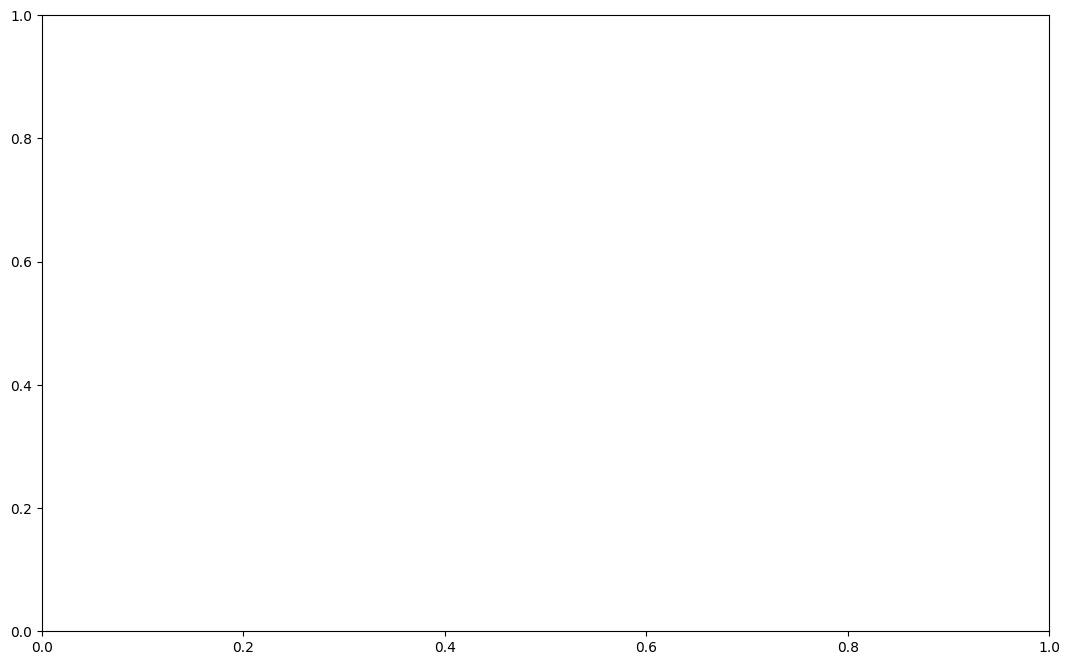

In [31]:
files = {
    'NN':  '../modeling/MLPRegressor_predictions_one_model.parquet',
    'RF':  '../modeling/RF_predictions_one_model.parquet',
    'XGB': '../modeling/XGB_predictions_one_model.parquet',
}
for path in files.values():
    tmp = pd.read_parquet(path)
    coins = tmp['filename'].str.split('_').str[0].str[:-3]
    all_coins |= set(coins.unique())
coin_names = sorted(all_coins)
x = np.arange(len(coin_names))

fig, ax = plt.subplots(figsize=(13, 8))